In [1]:
import tensorflow as tf 
import numpy as np 

x_train = np.arange(10).reshape((10,1))
y_train = np.array([1.0, 1.3, 3.1,
                     2.0, 5.0, 6.3,
                     6.6, 7.4, 8.0, 9.0])

In [2]:
class Tflingreg():
    def __init__(self,x_dim,learning_rate = 0.01,random_seed = None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(random_seed)
            
            self.build()
            self.init_op = tf.global_variables_initializer()
    def build(self):
        self.x = tf.placeholder(dtype = tf.float32,
                                shape = (None,self.x_dim),
                                name = "x_input")
        
        self.y = tf.placeholder(dtype = tf.float32,
                        shape = (None),
                        name = "y_input")
        
        w = tf.Variable(tf.zeros(shape = (1)), name = "weight")
        
        b = tf.Variable(tf.zeros(shape=(1)), name="bias")
        
        self.z_net = tf.squeeze(w* self.x + b,name = "z_net")
        
        sqr_errors = tf.square(self.y - self.z_net,name = "sqr_errors")
        
        self.mean_cost = tf.reduce_mean(sqr_errors,name = "mean_cost")
        
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate = self.learning_rate,
            name = "GradientDescent" 
        )
        
        self.optimizer = optimizer.minimize(self.mean_cost)
        
        
        
def train_linreg(sess,model,x_train,y_train,num_epochs = 10):
    sess.run(model.init_op)
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer,model.mean_cost],
                           feed_dict = {model.x : x_train,
                                        model.y : y_train})
        
        training_costs.append(cost)
    return training_costs

def predict_linreg(sess,model,x_test):
    y_pred = sess.run(model.z_net,feed_dict = {
        model.x:x_test
    })
    return y_pred

In [3]:
lrmodel = Tflingreg(x_dim = x_train.shape[1],learning_rate = 0.01)

sess = tf.Session(graph = lrmodel.g)
training_costs = train_linreg(sess,lrmodel,x_train,y_train)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


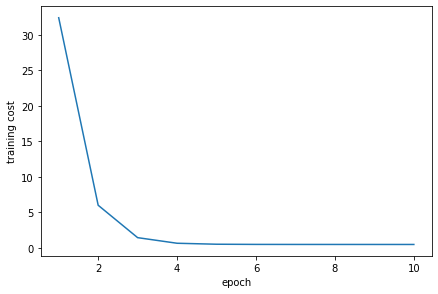

In [5]:
import matplotlib.pyplot as plt 
plt.plot(range(1,len(training_costs) + 1 ), training_costs)
plt.tight_layout()
plt.xlabel("epoch")
plt.ylabel("training cost")
plt.show()

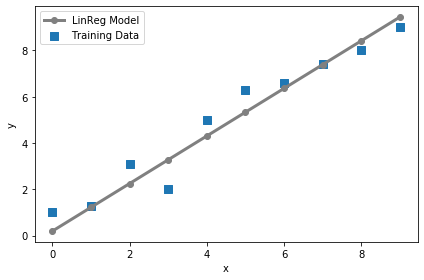

In [6]:
plt.scatter(x_train, y_train,
             marker='s', s=50,
             label='Training Data')
plt.plot(range(x_train.shape[0]),
          predict_linreg(sess, lrmodel, x_train),
          color='gray', marker='o',
          markersize=6, linewidth=3,
          label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd 
import numpy as np
df = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/3004/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1561715431&Signature=j%2BRVJvjNgBVXUPYBlnIj3zuAH0tLIEJsnjWm7%2FAHdt4kXHBGRA%2BebupBzf%2B8xPO7hlH6XlcuXFQPluvnFokrNazZ6QQG73Ms6dpapBOmwR%2BMgiCpcwCErljWZjhaaDllsKcQbW86iLFm0ankDHjAazu8emdH8V4rQU3QJqkeu%2BtUGVPwr78sHvb2gMMwWKRedNiOhP2gOUMf1lGwtWdC%2FQzt6aOfbaoiDtqdxav59HLJdfM00bJTaFkZ16wa7vDDDRBOAg2KAOAt%2BSCcgI6xJNjR0Ou1TyepsLvO6s3uyFCKswE7YiiT7bJaoshPtQAAOj0ewYH5B9iqoefSKI%2BpYA%3D%3D")

from sklearn.model_selection import train_test_split

x = df.iloc[:,1:].values
y = df.iloc[:,0].values

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                test_size = 0.3,
                                                random_state = 0)

mean_vals = np.mean(x_train, axis=0)
std_val = np.std(x_train)
x_train_centered = (x_train - mean_vals)/std_val
x_test_centered = (x_test - mean_vals)/std_val

In [8]:
import tensorflow as tf

n_features = x_train_centered.shape[1]

n_classes = 10
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32,
                       shape=(None, n_features),
                       name='tf_x')

    tf_y = tf.placeholder(dtype=tf.int32,
                        shape=None, name='tf_y')
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)

    h1 = tf.layers.dense(inputs=tf_x, units=50,
                         activation=tf.tanh,
                         name='layer1')

    h2 = tf.layers.dense(inputs=h1, units=50,
                         activation=tf.tanh,
                         name='layer2')

    logits = tf.layers.dense(inputs=h2,
                             units=10,
                             activation=None,
                             name='layer3')

    predictions = {
        'classes' : tf.argmax(logits, axis=1,
                              name='predicted_classes'),
        'probabilities' : tf.nn.softmax(logits,
                              name='softmax_tensor')
    }

    cost = tf.losses.softmax_cross_entropy(
            onehot_labels=y_onehot, logits=logits)

    optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=0.001)

    train_op = optimizer.minimize(
            loss=cost)

    init_op = tf.global_variables_initializer()
    
def create_batch_generator(x, y, batch_size=128, shuffle=False):
    x_copy = np.array(x)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((x_copy, y_copy))
        np.random.shuffle(data)
        x_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
    
    for i in range(0, x.shape[0], batch_size):
        yield (x_copy[i:i+batch_size, :], y_copy[i:i+batch_size])
        
        

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [9]:

sess =  tf.Session(graph=g)
 ## run the variable initialization operator
sess.run(init_op)
## 50 epochs of training:
for epoch in range(50):
    training_costs = []
    batch_generator = create_batch_generator(x_train_centered, y_train,
          batch_size=64, shuffle=True)
    for batch_X, batch_y in batch_generator:
      ## prepare a dict to feed data to our network:
        feed = {tf_x:batch_X, tf_y:batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
    print(' -- Epoch %2d  '
           'Avg. Training Loss: %.4f' % (
              epoch+1, np.mean(training_costs)
    ))




 -- Epoch  1  Avg. Training Loss: 1.8689
 -- Epoch  2  Avg. Training Loss: 1.2630
 -- Epoch  3  Avg. Training Loss: 1.0256
 -- Epoch  4  Avg. Training Loss: 0.8856
 -- Epoch  5  Avg. Training Loss: 0.7897
 -- Epoch  6  Avg. Training Loss: 0.7189
 -- Epoch  7  Avg. Training Loss: 0.6640
 -- Epoch  8  Avg. Training Loss: 0.6201
 -- Epoch  9  Avg. Training Loss: 0.5841
 -- Epoch 10  Avg. Training Loss: 0.5539
 -- Epoch 11  Avg. Training Loss: 0.5284
 -- Epoch 12  Avg. Training Loss: 0.5063
 -- Epoch 13  Avg. Training Loss: 0.4871
 -- Epoch 14  Avg. Training Loss: 0.4702
 -- Epoch 15  Avg. Training Loss: 0.4555
 -- Epoch 16  Avg. Training Loss: 0.4419
 -- Epoch 17  Avg. Training Loss: 0.4292
 -- Epoch 18  Avg. Training Loss: 0.4186
 -- Epoch 19  Avg. Training Loss: 0.4083
 -- Epoch 20  Avg. Training Loss: 0.3989
 -- Epoch 21  Avg. Training Loss: 0.3903
 -- Epoch 22  Avg. Training Loss: 0.3827
 -- Epoch 23  Avg. Training Loss: 0.3748
 -- Epoch 24  Avg. Training Loss: 0.3679
 -- Epoch 25  Av

In [15]:

feed = {tf_x : x_test_centered}
y_pred_test = sess.run(predictions['classes'],
                 feed_dict=feed)
print('Test Accuracy: %.2f%%' % ( 100*np.sum(y_pred == y_test)/y_test.shape[0]))



Test Accuracy: 92.32%


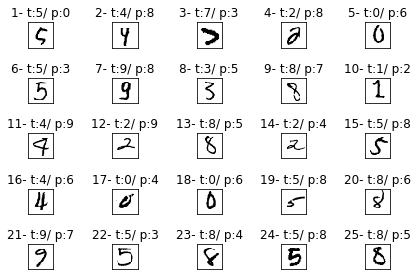

In [16]:
miscl_img = x_test[y_test != y_pred_test][:25]


correct_lab = y_test[y_test != y_pred_test][:25]
miscl_lab = y_pred_test[y_test != y_pred_test][:25]

fig,ax = plt.subplots(nrows = 5,
                     ncols =5,
                     sharex = True,
                     sharey = True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28,28)
    ax[i].imshow(img,cmap = "Greys",interpolation = "nearest")
    ax[i].set_title("{0}- t:{1}/ p:{2}".format(i+1,correct_lab[i],miscl_lab[i]) )
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()